In [1]:
import os, sys

sys.path.insert(0, "C:\\Users\\rudma\\Documents\\code\\mcsimpy\\src")

In [2]:
# Imports Gunnerus model
from mcsimpy.simulator.gunnerus import RVG_DP_6DOF
# Imports waves
from mcsimpy.waves import JONSWAP, WaveLoad

from DT.holtrop_mennen_resistance import *

# Imports utilities
import numpy as np

In [9]:
dt = 0.1
simtime = 5400
t = np.arange(0, simtime, dt)

vessel = RVG_DP_6DOF(dt=dt, method='RK4')

Uc = 0.0
beta_c = 0

eta = np.zeros((6, len(t)))
nu = np.zeros((6, len(t)))


hs = 1.0 # Significant wave height
tp = 9.0 # Peak period
gamma = 1.3 # Peak factor
wp = 2*np.pi/tp # Peak frequency
wmin = 0.5*wp
wmax = 3.0*wp
np.random.seed(1)

N = 100 # Number of wave components

wave_freqs = np.linspace(wmin, wmax, N)

jonswap = JONSWAP(wave_freqs)

_, wave_spectrum = jonswap(hs=hs, tp=tp, gamma=gamma)

dw = (wmax - wmin) / N
wave_amps = np.sqrt(2 * wave_spectrum * dw)
rand_phase = np.random.uniform(0, 2*np.pi, size=N)
wave_angles = np.ones(N) * np.deg2rad(180)

#Wave elevation
eta_wave = np.zeros(len(t))
for i_freq in range(N):
    eta_wave += wave_amps[i_freq] * np.cos(wave_freqs[i_freq] * t + rand_phase[i_freq])
wave_height = eta_wave

waveload = WaveLoad(
    wave_amps=wave_amps,
    freqs=wave_freqs,
    eps=rand_phase,
    angles=wave_angles,
    config_file=vessel._config_file,
    interpolate=True,
    qtf_method="geo-mean",      # Use geometric mean to approximate the QTF matrices.
    deep_water=True,            # Assume deep water conditions.
)

# Simulation loop

vel = []
resistance = []
wave_force = []
tau_total = []
thrust = []
zeta = []
power = []

for i in range(len(t)): 
    tau_resistance = get_total_resistance(vessel.get_nu())
    tau_wave = waveload(t[i], vessel.get_eta())
    tau_wave = np.array([tau_wave[0], tau_wave[1], 0, 0, 0, tau_wave[5]])
    
    #thrust_levels = [30000, 40000, 50000, 40000, 30000, 40000, 55000, 50000, 45000]

    thrust_levels = [3000, 5000, 10000, 15000, 20000, 30000, 40000, 50000, 55000]
    
    thrust_duration = 600
    ramp_time = 100  # ramp time
    
    t_val = t[i]
    level_idx = int(t_val // thrust_duration)
    t_in_segment = t_val % thrust_duration
    
    if level_idx < len(thrust_levels) - 1:
        thrust_start = thrust_levels[level_idx]
        thrust_end = thrust_levels[level_idx + 1]
    
        if t_in_segment < (thrust_duration - ramp_time):
            # Hold constant thrust
            current_thrust = thrust_start
        else:
            # Linearly ramp to next level
            alpha = (t_in_segment - (thrust_duration - ramp_time)) / ramp_time
            current_thrust = (1 - alpha) * thrust_start + alpha * thrust_end
    else:
        current_thrust = thrust_levels[-1]
    
    tau_control = np.array([current_thrust, 0, 0, 0, 0, 0])
    
    tau = tau_control + np.array([tau_wave[0], 0, 0, 0, 0, 0])
    eta[:, i] = vessel.get_eta()
    nu[:, i] = vessel.get_nu()
    vessel.integrate(Uc, beta_c, tau)
    
    resistance.append(tau_resistance[0])
    tau_total.append(tau)
    thrust.append(tau_control[0])
    wave_force.append(-tau_wave[0])
    vel.append(vessel.get_nu())
    zeta.append(wave_height[i])
    power.append(tau_control[0] * vessel.get_nu()[0] / 0.65 / 1000 * 2) #0.65 efficiency



***************************************Generate QTF matrices****************************************
Using Geometric mean

***************************************QTF matrices complete.***************************************


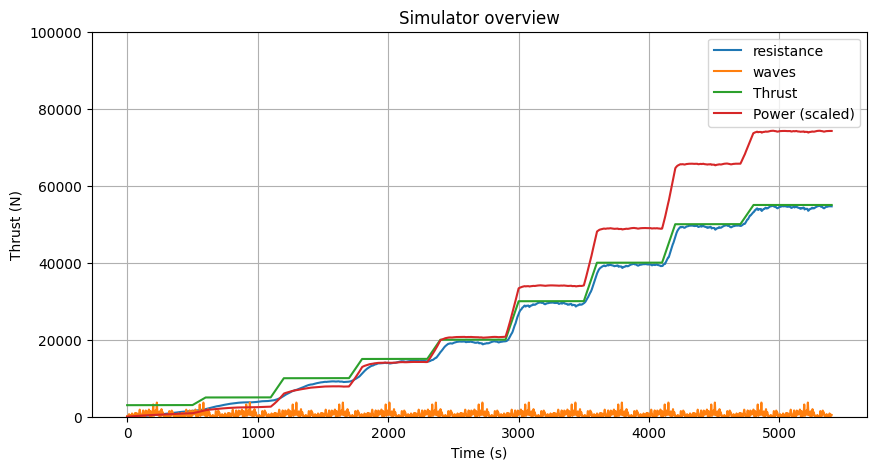

In [10]:
plt.subplots(figsize=(10, 5))
#plt.plot(t, tau_total, label="Tau")
plt.plot(t, resistance, label="resistance")
plt.plot(t, wave_force, label="waves")
plt.plot(t, thrust, label="Thrust")
plt.plot(t, np.array(power)*70, label = 'Power (scaled)')
plt.title('Simulator overview')
plt.xlabel("Time (s)")
plt.ylabel("Thrust (N)")
plt.legend()
plt.ylim(0, 100000)
plt.grid()
#plt.savefig("pythonsim_overview.eps", format='eps')
plt.show()

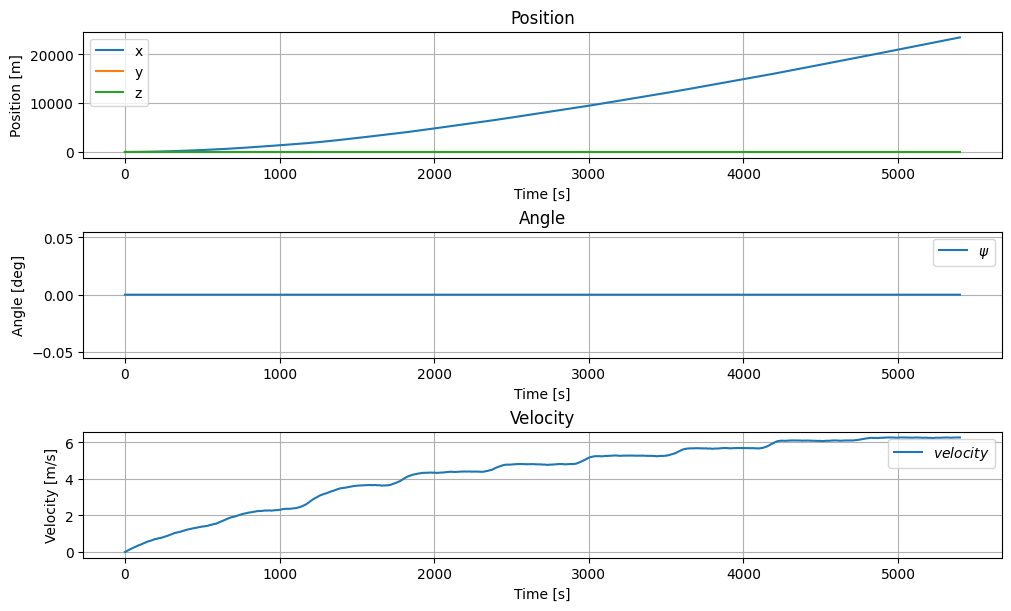

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), constrained_layout=True)
axes[0].plot(t, eta[0, :], label='x')
axes[0].plot(t, eta[1, :], label='y')
axes[0].plot(t, eta[2, :], label='z')
axes[0].legend()
axes[0].grid()
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Position [m]')
axes[0].set_title('Position')

axes[1].plot(t, np.degrees(eta[5, :]), label=r"$\psi$")
axes[1].legend()
axes[1].grid()
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Angle [deg]')
axes[1].set_title('Angle')

vel = np.array(vel)
axes[2].plot(t, vel[:, 0], label=r"$velocity$")
axes[2].legend()

axes[2].grid()
axes[2].set_xlabel('Time [s]')
axes[2].set_ylabel('Velocity [m/s]') 
axes[2].set_title('Velocity')

#plt.savefig("sim_pos_deg_vel.eps", format='eps')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

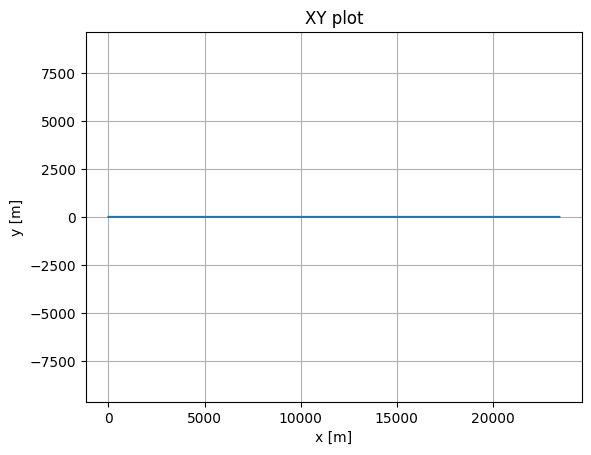

In [12]:
# Plot XY plot to position
plt.figure()
plt.plot(eta[0, :], eta[1, :])

# Plot orientation of the vessel described by arrows for every 30th time step
for i in range(0, len(t), 400):
    plt.arrow(eta[0, i], eta[1, i], 0.1* np.cos(eta[5, i]), 0.1*np.sin(eta[5, i]), head_width=0.05, head_length=0.05)


plt.axis('equal')
plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('XY plot')
plt.show

In [ ]:
file saving
# Convert lists to arrays
vel_arr = np.array(vel)[:, 0]           # surge velocity
resistance_arr = np.array(resistance)
wave_force_arr = np.array(wave_force)
thrust_arr = np.array(thrust)
wave_height_arr = np.array(zeta)
power_arr = np.array(power)            

# Repeat Hs/Tp across time
hs_arr = np.full_like(thrust_arr, hs, dtype=np.float32)
tp_arr = np.full_like(thrust_arr, tp, dtype=np.float32)

# input
X = np.column_stack([
    thrust_arr,
    wave_height_arr,
    hs_arr,
    tp_arr,
    vel_arr 
])

# output
y = power_arr.reshape(-1, 1)

# Save to .npz
np.savez(
    f"sim_hs{hs}_tp{tp}_seed6.npz",
    X=X,
    y=y,
    time=t,
    resistance=resistance_arr,
    wave_force=wave_force_arr,
    velocity=vel_arr,
    power=power_arr
)

print("✅ Saved: Inputs = thrust, wave, hs, tp, velocity → Predicting power")
